In [1]:
from nibabel import load, save, Nifti1Image
from numpy import absolute

analysis = ['age','Temper_Loss','General_Aggression']

home = '/moochie/Cat/Aggregate_anats/GMD_ML/ml_trainingset/'

for a in analysis:
    file = home + 'svrweights_%s_LOSO.nii.gz' % a
    temp_nii = load(file)
    temp_data = temp_nii.get_data()
    new_data = absolute(temp_data)
    new_nii = Nifti1Image(new_data,header=temp_nii.header,affine=temp_nii.affine)
    new_file = home + 'clusters/svrABSweights_%s_LOSO.nii.gz' % a
    save(new_nii,new_file)

In [4]:
from nipype.interfaces.fsl import Cluster

analysis = ['age','Temper_Loss','General_Aggression']

for a in analysis:
    file = home + 'clusters/svrABSweights_%s_LOSO.nii.gz' % a
    cl = Cluster()
    cl.inputs.in_file = file
    cl.inputs.out_localmax_txt_file = home + 'clusters/cluster_stats_%s.txt' % a
    cl.inputs.threshold = 0.000001
    cl.inputs.out_index_file = home + 'clusters/clusters_%s.nii.gz' % a
    cl.run()

190424-08:42:34,119 interface INFO:
	 stdout 2019-04-24T08:42:34.118840:Cluster Index	Voxels	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)
190424-08:42:34,122 interface INFO:
	 stdout 2019-04-24T08:42:34.118840:472	13226	0.000473	118	118	140	124	99.9	115
190424-08:42:34,123 interface INFO:
	 stdout 2019-04-24T08:42:34.118840:471	6628	0.00038	121	140	171	124	163	164
190424-08:42:34,124 interface INFO:
	 stdout 2019-04-24T08:42:34.118840:470	4841	0.000356	161	141	127	164	144	133
190424-08:42:34,126 interface INFO:
	 stdout 2019-04-24T08:42:34.118840:469	4120	0.000364	94	161	131	87.8	148	131
190424-08:42:34,128 interface INFO:
	 stdout 2019-04-24T08:42:34.118840:468	3275	0.000451	172	128	178	174	114	181
190424-08:42:34,129 interface INFO:
	 stdout 2019-04-24T08:42:34.118840:467	2825	0.000376	91	142	137	108	142	134
190424-08:42:34,131 interface INFO:
	 stdout 2019-04-24T08:42:34.118840:466	2361	0.000388	173	82	94	172	91.2	95.4
190424-08:42:34,133 interface INF

In [1]:
home = '/moochie/Cat/Aggregate_anats/GMD_ML/ml_trainingset/'

def extract_cluster_betas(cluster_index_file, sample_betas, min_clust_size, subject_ids):
    from nibabel import load, save, Nifti1Image
    from pandas import DataFrame, Series
    from numpy import unique, zeros_like, invert
    from nipype.interfaces.fsl.utils import ImageMeants
    from os.path import abspath, basename
    
    subject_ids = sorted(subject_ids)
    sample_data = DataFrame(subject_ids, index=None, columns=['Subject'])
    
    cluster_nifti = load(cluster_index_file)
    cluster_data = cluster_nifti.get_data()
    clusters, cluster_sizes = unique(cluster_data, return_counts=True)
    cluster_sizes = cluster_sizes[clusters>min_clust_size]
    clusters = clusters[clusters>min_clust_size]
    ind_filename = basename(cluster_index_file) 
    out_prefix = ind_filename[:-7]
    
    for clust_idx in clusters:
        temp = zeros_like(cluster_data)
        temp[cluster_data==clust_idx] = 1
        temp_nii = Nifti1Image(temp,cluster_nifti.affine)
        temp_file = 'temp_clust_mask.nii.gz'
        save(temp_nii, temp_file)

        eb = ImageMeants()
        eb.inputs.in_file = sample_betas
        eb.inputs.mask = temp_file
        eb.inputs.out_file = 'values.txt'
        eb.run()
        betas = open('values.txt').read().splitlines()
        sample_data['clust' + str(clust_idx)] = Series(betas, index=sample_data.index)
    
    sample_data.to_csv(out_prefix+'_extracted_values.csv')
    extracted_betas_csv = abspath(out_prefix+'_extracted_values.csv')
    
    print('###### ' + out_prefix + ' #######')
    print('cluster labels: '+str(clusters))
    print('cluster sizes: '+str(cluster_sizes))
    return(extracted_betas_csv)

In [2]:
from glob import glob
from pandas import read_csv
index_files = glob(home + 'clusters/clusters_*.nii.gz')
sample_betas = home + 'gmd_combined.nii.gz'
subject_info = read_csv(home + 'featureset_key.csv',index_col=0)

subject_ids = subject_info['subject']
min_clust_size = 50

for clusters in index_files:
    extract_cluster_betas(clusters, sample_betas, min_clust_size, subject_ids)

###### clusters_age #######
cluster labels: [ 51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248
 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266
 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284
 285 28

In [8]:
def get_cluster_peaks(clusters_file, stat_file):
    from nibabel import load, save, Nifti1Image
    from pandas import DataFrame, Series
    from numpy import unique, unravel_index, max
    
    # load up clusters
    clusters_nii = load(clusters_file)
    clusters_data = clusters_nii.get_data()
    cluster_labels, cluster_sizes = unique(clusters_data, return_counts=True)
    cluster_sizes = cluster_sizes[cluster_labels>0]
    cluster_labels = cluster_labels[cluster_labels>0]
    
    # set up dataframe
    cluster_info = DataFrame(columns=['clust_num','peak','num_voxels','X','Y','Z'])
    cluster_info['clust_num'] = Series(cluster_labels,index=None)
    
    for i in range(0,len(cluster_labels)):
        # load up stat image
        stat_nii = load(stat_file)
        stat_data = stat_nii.get_data()
        stat_data[clusters_data!=cluster_labels[i]]=0
        location=unravel_index(stat_data.argmax(), stat_data.shape)
        cluster_info.iloc[i,0]=cluster_labels[i]
        cluster_info.iloc[i,1]=max(stat_data)
        cluster_info.iloc[i,2]=cluster_sizes[i]
        cluster_info.iloc[i,3]=location[0]
        cluster_info.iloc[i,4]=location[1]
        cluster_info.iloc[i,5]=location[2]
    
    out_prefix = clusters_file[:-7]
    cluster_info.to_csv(out_prefix + '_peaks.csv')
    return(cluster_info)

In [12]:
index_files = glob(home + 'clusters/clusters_*.nii.gz')
index_files = sorted(index_files)

stat_files=glob(home + 'clusters/svrABSweights*.nii.gz')
stat_files = sorted(stat_files)

for j in range(0,len(stat_files)):
    get_cluster_peaks(index_files[j], stat_files[j])

In [25]:
from pandas import read_csv, DataFrame, merge
study_home = '/moochie/Cat/Aggregate_anats/GMD_ML'
sub_data_file = study_home + '/doc/subjectinfo.csv'

subject_info = read_csv(sub_data_file, index_col=None)
cluster_info = read_csv('/moochie/Cat/Aggregate_anats/GMD_ML/ml_trainingset/clusters_irritability_extracted_values.csv',index_col=0)

new = subject_info.merge(cluster_info, left_on='Subject', right_on='Subject')
new.columns


Index(['Subject', 'Study', 'SequenceVersion', 'PotentiallyUsable',
       'in_analysis', 'Dx_Group', 'Age_yrs', 'Age_mos', 'male', 'cbq_activity',
       'cbq_angfru', 'cbq_approach', 'cbq_attentionfocus', 'cbq_discomfort',
       'cbq_soothability', 'cbq_fear', 'cbq_hip', 'cbq_impulsivity',
       'cbq_inhibtctl', 'cbq_lip', 'cbq_perceptsens', 'cbq_sad', 'cbq_shy',
       'cbq_smilelaugh', 'map_temploss', 'clust1', 'clust2', 'clust3',
       'clust4', 'clust5', 'clust6', 'clust7', 'clust8', 'clust9', 'clust10',
       'clust11', 'clust12', 'clust13', 'clust14', 'clust15', 'clust16',
       'clust17', 'clust18', 'clust19', 'clust20', 'clust21', 'clust22',
       'clust23', 'clust24', 'clust25', 'clust26', 'clust27', 'clust28',
       'clust29', 'clust30', 'clust31', 'clust32', 'clust33', 'clust34',
       'clust35', 'clust36', 'clust37', 'clust38', 'clust39', 'clust40',
       'clust41', 'clust42', 'clust43', 'clust44', 'clust45', 'clust46'],
      dtype='object')

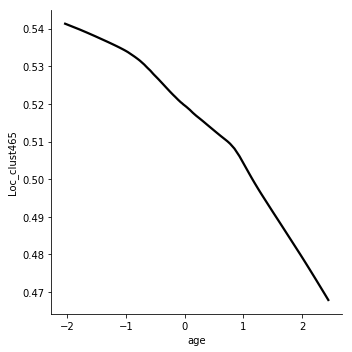

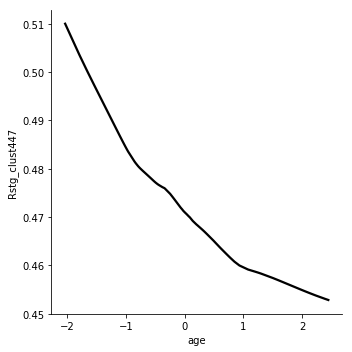

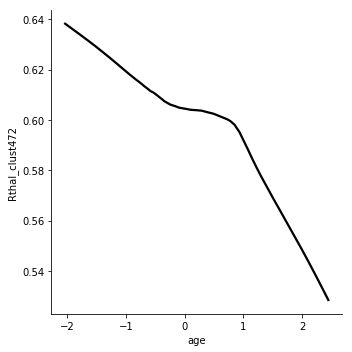

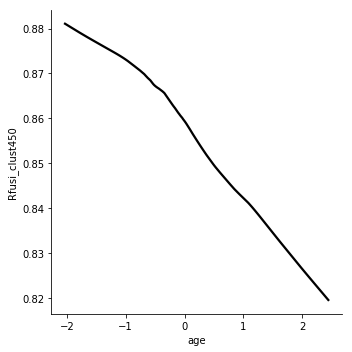

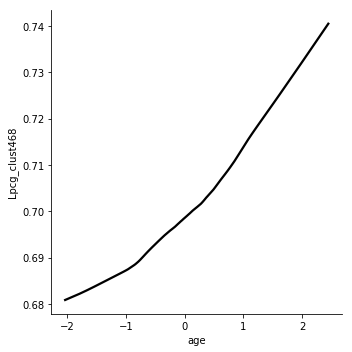

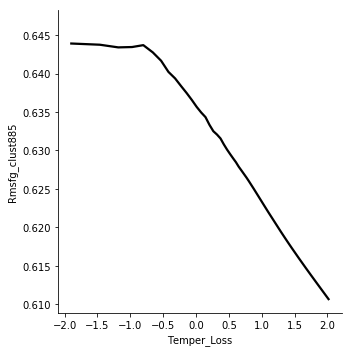

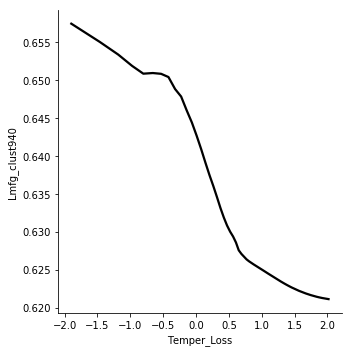

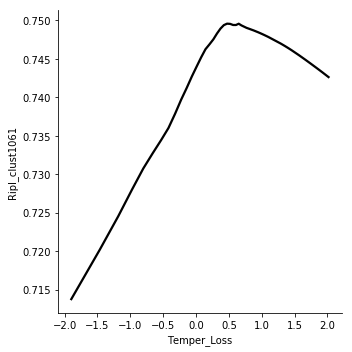

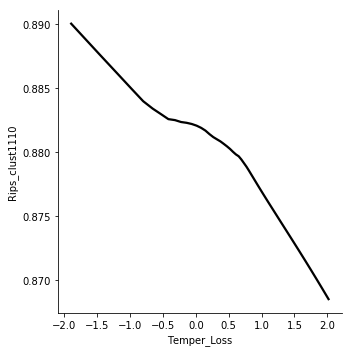

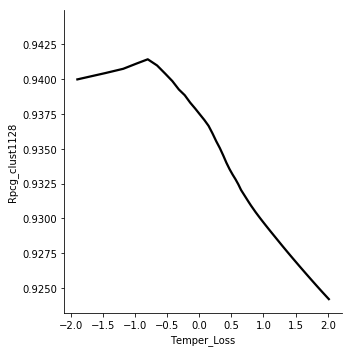

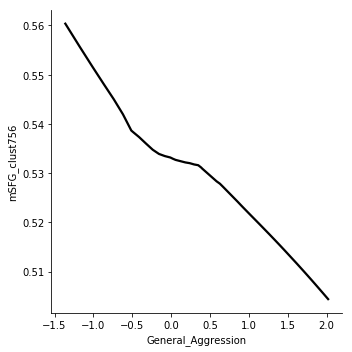

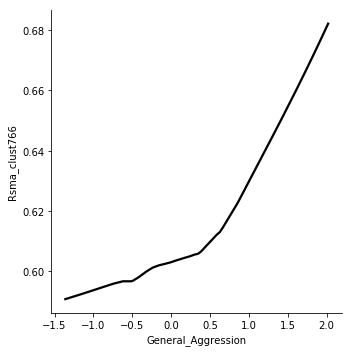

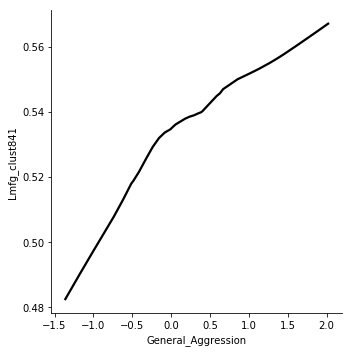

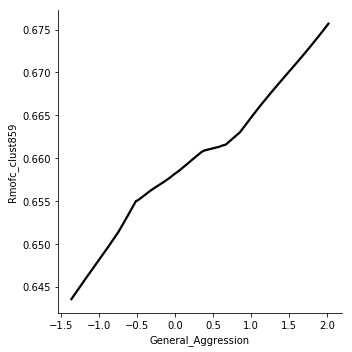

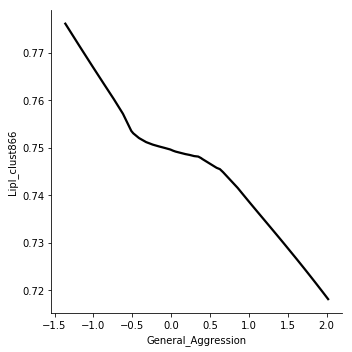

In [4]:
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns

data = read_csv('/moochie/Cat/Aggregate_anats/GMD_ML/ml_trainingset/clusters/GMDforfigures.csv',index_col=0)

for reg in ['Loc_clust465','Rstg_clust447','Rthal_clust472','Rfusi_clust450','Lpcg_clust468']:
    sns.lmplot(x='age',y=reg,data=data, ci=None, lowess=True,scatter=False,line_kws={'color':'black'})
    plt.savefig('/moochie/Cat/Aggregate_anats/GMD_ML/ml_trainingset/clusters/age_'+reg+'_lowess.svg')
    
for reg in ['Rmsfg_clust885','Lmfg_clust940','Ripl_clust1061','Rips_clust1110','Rpcg_clust1128']:
    sns.lmplot(x='Temper_Loss',y=reg,data=data, ci=None, lowess=True,scatter=False,line_kws={'color':'black'})
    plt.savefig('/moochie/Cat/Aggregate_anats/GMD_ML/ml_trainingset/clusters/TL_'+reg+'_lowess.svg')
    
for reg in ['mSFG_clust756','Rsma_clust766','Lmfg_clust841','Rmofc_clust859','Lipl_clust866']:
    sns.lmplot(x='General_Aggression',y=reg,data=data, ci=None, lowess=True,scatter=False,line_kws={'color':'black'})
    plt.savefig('/moochie/Cat/Aggregate_anats/GMD_ML/ml_trainingset/clusters/GA_'+reg+'_lowess.svg')